In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bemcs
import warnings

warnings.filterwarnings("ignore")

# Using equivalent body forces to compute Greens functions in heterogeneous media (antiplane)

The basic premise in this method is that point force solutions to the Laplace Equation can be used to construct the Greens Functions with the necessary deviations from a homogeneous elastic medium. To start, we know that equilibrium equations in antiplane strain appear as:

$$
\nabla\cdot\sigma = 0
$$, where $\sigma = \begin{bmatrix} \sigma_x & \sigma_y \end{bmatrix}$

For arbitrary material properties linear elasticity provides us with the following equation for each component,

$$
\sigma_i(x,y) = \mu(x,y)\epsilon_i(x,y)
$$, 

where $\epsilon_i(x,y) = \frac{1}{2}u_{,i}(x,y)$. Plugging this into equilibrium equations gives,

$$
\frac{\mu}{2}\nabla^2 u + \frac{1}{2}\left(\mu_{,x}u_{,x} + \mu_{,y}u_{,y} \right) = 0
$$

Considering we compute homogeneous Greens Functions for 

$$
\nabla^2 \mathcal{G}(x,y;x_0,y_0) = \delta(x-x_0,y-y_0)
$$ ,

we can simply rearrange to get an equivalent body force due to heterogeneous materials,

$$
\nabla^2 u = -\frac{1}{\mu}\left(\mu_{,x}u_{,x} + \mu_{,y}u_{,y} \right) = \alpha u_{,x} + \beta u_{,y}
$$ 
where $\alpha,\beta$ are the spatial logarithmic gradients of $\mu$ i.e., $\frac{\mu_{,i}}{\mu}$. The right side contains all the terms related to heterogeneity, which turn out to be linear in $u_{,i}$, and so are perfectly suited for Greens Functions calculations.


## Setup geometry

For this problem we first setup the source we want to compute Greens Functions for. In this case, it is a slip source. And since we care about a free surface, we also mesh topography with a flat interface.

In [2]:
# Elastic parameter (shear modulus)
mu = 1.0
Lscale = 50
npts_layer = 101

els_source = bemcs.initialize_els()
els_topo = bemcs.initialize_els()
els_b = bemcs.initialize_els()
els = bemcs.initialize_els()

# setup a fault geometry (source)
els_source.x1 = np.array([-0.0])
els_source.y1 = np.array([-0.5])
els_source.x2 = np.array([0.0])
els_source.y2 = np.array([-1e6])
bemcs.standardize_els_geometry(els_source, reorder=False)

# topography
xvals = np.linspace(-Lscale, Lscale, npts_layer)
els_topo.x1 = xvals[0:-1]
els_topo.x2 = xvals[1:]
els_topo.y1 = np.zeros_like(els_topo.x1)
els_topo.y2 = np.zeros_like(els_topo.x1)
bemcs.standardize_els_geometry(els_topo, reorder=False)

## Compute $\alpha,\beta$ for heterogeneous medium

In this problem, we only consider vertical stratification, so $\mu_{,x} = 0$ and so $\alpha = 0$. The trick with computing $\beta$ is to consider step changes in elastic properties by using an asymptotic at a given $k^{th}$ interface i.e., $\beta_k = \frac{\mu_k-\mu_{k+1}}{\mu_{k+1}}$ 

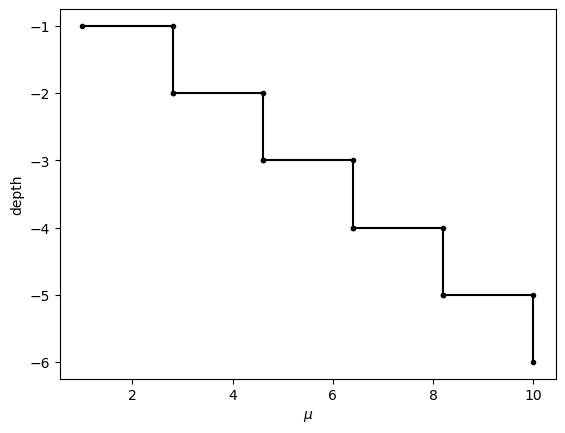

In [3]:
# provide layered structure in terms of number of layers, location of layers (iterface with jump in μ), and μ values
nlayers = 5
zlayer = np.linspace(-5, 0, nlayers + 1)[0:-1]
mulayer = np.linspace(10, 1, nlayers + 1)
x1 = []
x2 = []
y1 = []
y2 = []

# calculation the dμ/dx and dμ/dy terms as α,β
beta = np.ones(len(zlayer) * (npts_layer - 1))
for i in range(len(zlayer)):
    xvals = np.linspace(-Lscale, Lscale, npts_layer)
    x1 = np.hstack([x1, xvals[0:-1]])
    x2 = np.hstack([x2, xvals[1:]])
    y1 = np.hstack([y1, np.ones(npts_layer - 1) * zlayer[i]])
    y2 = np.hstack([y2, np.ones(npts_layer - 1) * zlayer[i]])
    beta[i * (npts_layer - 1) : (npts_layer - 1) * (i + 1)] = (
        -(mulayer[i + 1] - mulayer[i]) / mulayer[i + 1]
    )

els_b.x1 = x1
els_b.x2 = x2
els_b.y1 = y1
els_b.y2 = y2
bemcs.standardize_els_geometry(els_b, reorder=False)

# combine topo and layered structure
els.x1 = np.hstack([els_topo.x1, els_b.x1])
els.x2 = np.hstack([els_topo.x2, els_b.x2])
els.y1 = np.hstack([els_topo.y1, els_b.y1])
els.y2 = np.hstack([els_topo.y2, els_b.y2])

# label topo index
topoindex = np.hstack(
    [np.ones(len(els_topo.x1), dtype=bool), np.zeros(len(els_b.x1), dtype=bool)]
)

bemcs.standardize_els_geometry(els, reorder=False)
n_els = len(els.x1)

# bemcs.plot_els_geometry(els)
# plot elastic structure
plt.figure()
for i in range(nlayers):
    if i == 0:
        plt.plot(
            [mulayer[i], mulayer[i], mulayer[i + 1]],
            [zlayer[i] - 1, zlayer[i], zlayer[i]],
            "k.-",
        )
    else:
        plt.plot(
            [mulayer[i], mulayer[i], mulayer[i + 1]],
            [zlayer[i - 1], zlayer[i], zlayer[i]],
            "k.-",
        )
plt.xlabel("$\mu$")
plt.ylabel("depth")
plt.show()

## Compute source strains at the location of the mesh

For a given slip source we compute the appropriate strain components at the topographic and body force mesh

$$
[u_{,x_0},u_{,y_0}] = \mathcal{G}\cdot s_0
$$
where $s_0$ is the slip source

In [4]:
dr = -1e-9
xo = els.x_centers + dr * els.x_normals
yo = els.y_centers + dr * els.y_normals
K_sx, K_sy, _ = bemcs.get_displacement_stress_kernel_slip_antiplane(
    xo, yo, els_source, mu
)
quadcoefs = np.ones(3)

# compute strain due to source at els
ex0 = 2 * K_sx @ quadcoefs
ey0 = 2 * K_sy @ quadcoefs

## Construct BEM kernel

To construct the Boundary Element kernel to solve the heterogeneous problem, we need to first discuss how the body force kernels can be written as matrix equations to solve this problem. 

We need a distribution of body forces $[\phi_t(\mathbf{x_t}),\phi_b(\mathbf{x_b})]$ where $t,b$ refer to topographic and material boundaries respectively. To understand the procedure, let's start with a simpler case where we somehow already know $\phi_t$. In that case the material boundary force equations are,

$$
\alpha(\mathbf{x_b})\left(u_{,x_0}(\mathbf{x_b}) + \mathcal{G}_{,x}(\mathbf{x_b};\mathbf{x_b})\cdot\phi_b(\mathbf{x_b}) + \mathcal{G}_{,x}(\mathbf{x_b};\mathbf{x_t})\cdot\phi_t(\mathbf{x_t}) \right) + 
\beta(\mathbf{x_b})\left(u_{,y_0}(\mathbf{x_b}) + \mathcal{G}_{,y}(\mathbf{x_b};\mathbf{x_b})\cdot\phi_b(\mathbf{x_b}) + \mathcal{G}_{,y}(\mathbf{x_b};\mathbf{x_t})\cdot\phi_t(\mathbf{x_t}) \right) = 
\phi_b(\mathbf{x_b})
$$

At the topographic surface, we can compute $\phi_t$ by applying an appropriate traction boundary condition and solving the following system of equations:
$$
 \frac{\mu(\mathbf{x_t})}{2}\left(n_xu_{,x_0}(\mathbf{x_t}) + n_yu_{,y_0}(\mathbf{x_t}) + 
 \left[n_x\mathcal{G}_{,x}(\mathbf{x_t};\mathbf{x_t}) + n_y\mathcal{G}_{,y}(\mathbf{x_t};\mathbf{x_t})\right]\cdot\phi_t(\mathbf{x_t}) + 
 \left[n_x\mathcal{G}_{,x}(\mathbf{x_t};\mathbf{x_b}) + n_y\mathcal{G}_{,y}(\mathbf{x_t};\mathbf{x_b})\right]\cdot\phi_b
 \right)(\mathbf{x_t})  = 
 t(\mathbf{x_t})
$$

So that gives us two sets of equations: 
1. Body force equivalents in terms of source strains and topographic forces
2. Traction-free boundary as a function of source strains and material boundary forces

### Governing equations
Putting it together, we get the following system of equations:

$$
\begin{bmatrix} \phi_t \\ \phi_b \end{bmatrix} = 
\begin{bmatrix} 
-\left(\alpha\mathcal{G}_{,x}(\mathbf{x_b};\mathbf{x_t}) + \beta\mathcal{G}_{,y}(\mathbf{x_b};\mathbf{x_t})\right) & 
I - \left(\alpha\mathcal{G}_{,x}(\mathbf{x_b};\mathbf{x_b}) + \beta\mathcal{G}_{,y}(\mathbf{x_b};\mathbf{x_b})\right)
\\
n_x\mathcal{G}_{,x}(\mathbf{x_t};\mathbf{x_t}) + n_y\mathcal{G}_{,y}(\mathbf{x_t};\mathbf{x_t}) & 
n_x\mathcal{G}_{,x}(\mathbf{x_t};\mathbf{x_b}) + n_y\mathcal{G}_{,y}(\mathbf{x_t};\mathbf{x_b})
\end{bmatrix}^{-1}
\begin{bmatrix}
\alpha u_{,x_0}(\mathbf{x_b}) + \beta u_{,y_0}(\mathbf{x_b}) \\
\frac{2t(\mathbf{x_t})}{\mu(\mathbf{x_t})} - n_xu_{,x_0}(\mathbf{x_t}) - n_yu_{,y_0}(\mathbf{x_t})
\end{bmatrix}
$$
where $t(\mathbf{x_t})$ refers to arbitrary traction distribution as a boundary condition on the topographic surface.

### Case of purely vertical stratification
In the case of a layered elastic material, $\alpha = 0$ and we can neglect $u_{,x_0}$ and $t$ for a flat free surface. This gives us,

$$
\begin{bmatrix} \phi_t \\ \phi_b \end{bmatrix} = 
\begin{bmatrix} 
-\beta\mathcal{G}_{,y}(\mathbf{x_b};\mathbf{x_t}) & 
I - \beta\mathcal{G}_{,y}(\mathbf{x_b};\mathbf{x_b})
\\
\mathcal{G}_{,y}(\mathbf{x_t};\mathbf{x_t}) & 
\mathcal{G}_{,y}(\mathbf{x_t};\mathbf{x_b})
\end{bmatrix}^{-1}
\begin{bmatrix}
\beta u_{,y_0}(\mathbf{x_b}) \\
-u_{,y_0}(\mathbf{x_t})
\end{bmatrix}
$$

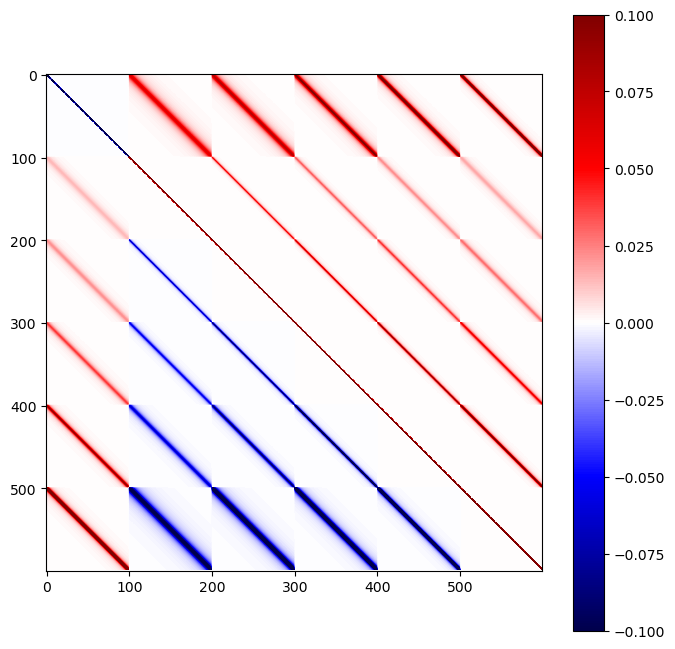

In [5]:
# compute els force kernels
K_sx, K_sy, _ = bemcs.get_displacement_stress_kernel_force_antiplane(xo, yo, els, mu)
# construct constant kernels from linear kernels for this simple example (multiply by 2 for ε -> du/dx)
K_x = np.zeros((n_els, n_els))
K_y = np.zeros((n_els, n_els))
for i in range(n_els):
    K_x[:, i] = 2 * (K_sx[:, 2 * i] + K_sx[:, 2 * i + 1])
    K_y[:, i] = 2 * (K_sy[:, 2 * i] + K_sy[:, 2 * i + 1])

kernel = np.vstack(
    [
        np.hstack([K_y[topoindex][:, topoindex], K_y[topoindex][:, ~topoindex]]),
        np.hstack(
            [
                -np.repeat(beta.reshape(-1, 1), len(els_topo.x1), axis=1)
                * K_y[~topoindex][:, topoindex],
                np.eye(len(els_b.x1))
                - np.repeat(beta.reshape(-1, 1), len(els_b.x1), axis=1)
                * K_y[~topoindex][:, ~topoindex],
            ]
        ),
    ]
)
plt.figure(figsize=(8, 8))
plt.imshow(kernel, cmap="seismic")
plt.colorbar()
plt.clim([-0.1, 0.1])
plt.show()

# solve system to get body forces
rhsvec = np.vstack(
    [-ey0[topoindex].reshape(-1, 1), (beta * ey0[~topoindex]).reshape(-1, 1)]
)
# print(np.linalg.cond(kernel))
solvec = np.linalg.pinv(kernel) @ rhsvec

# solve for purely topographic contribution
toposolvec = np.linalg.pinv(K_y[topoindex][:, topoindex]) @ (
    -ey0[topoindex].reshape(-1, 1)
)

# plt.figure()
# plt.plot(els_topo.x_centers, solvec[topoindex], "o-")
# plt.plot(els.x_centers[~topoindex], solvec[~topoindex], "k.")
# plt.xlim([-5, 5])
# plt.show()

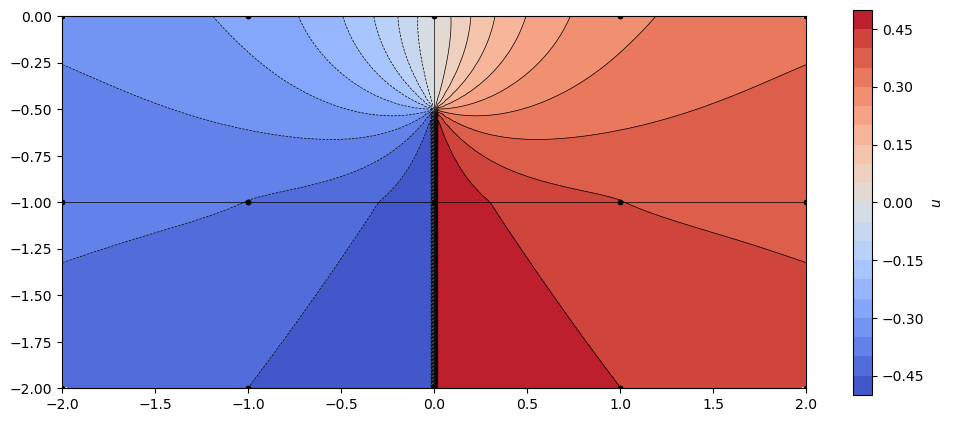

In [6]:
# plot resulting displacement field
nx_obs = 100
ny_obs = 100
x_obs = np.linspace(-2, 2, nx_obs)
y_obs = np.linspace(-2, 0, ny_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
xo = x_obs.flatten().reshape(-1, 1)
yo = y_obs.flatten().reshape(-1, 1)

_, _, K_u = bemcs.get_displacement_stress_kernel_force_antiplane(xo, yo, els, mu)
Ku = np.zeros((len(xo), n_els))
for i in range(n_els):
    Ku[:, i] = K_u[:, 2 * i] + K_u[:, 2 * i + 1]
_, _, Ku0 = bemcs.get_displacement_stress_kernel_slip_antiplane(xo, yo, els_source, mu)
# compute displacements
u = Ku @ solvec + Ku0 @ quadcoefs.reshape(-1, 1)
u_topo = Ku[:, topoindex] @ toposolvec + Ku0 @ quadcoefs.reshape(-1, 1)

plt.figure(figsize=(12, 5))
toplot = u.reshape(ny_obs, nx_obs)
maxval = 0.5
minval = -maxval
levels = np.linspace(minval, maxval, 21)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-", linewidth=0.5)
plt.colorbar(label="$u$")
plt.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="k",
    levels=levels,
    linewidths=0.5,
)
plt.xlim([-2, 2])
plt.ylim([-2, 0])
plt.gca().set_aspect("equal", adjustable="box")

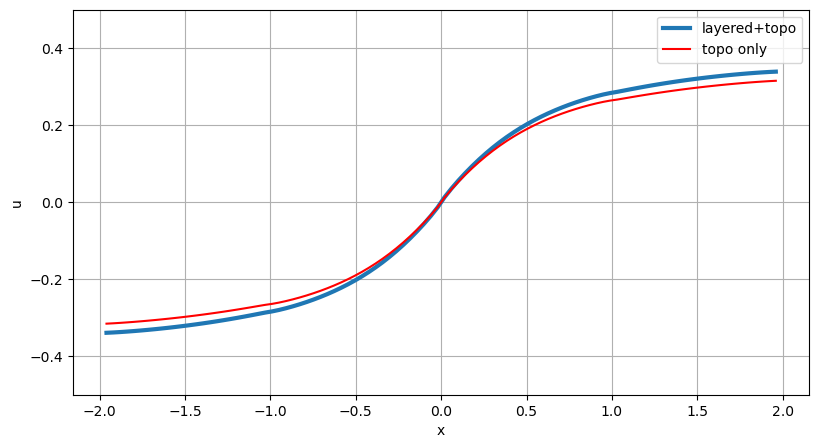

In [7]:
# plot 'u' only at the free surface
surfaceindex = yo == 0
plt.figure(figsize=(9.5, 5))
plt.plot(xo[surfaceindex], u[surfaceindex], "-", label="layered+topo", linewidth=3)
plt.plot(xo[surfaceindex], u_topo[surfaceindex], "r-", label="topo only")
# plt.plot(
#     xo[surfaceindex],
#     1 / np.pi * np.arctan(xo[surfaceindex] / 0.5),
#     "k--",
# )
plt.xlabel("x")
plt.ylabel("u")
plt.ylim([-0.5, 0.5])
plt.grid()
plt.legend()
plt.show()